In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_data(num_locations):
    np.random.seed(42)
    locations = np.random.randint(1,100,(num_locations,2)) #depot: location[0]
    num_customers = num_locations - 1

    return locations, num_customers

In [3]:
def calculate_distance(locations,num_locations):
    distances = np.zeros((num_locations,num_locations))
    for i in range(num_locations):
        for j in range(i+1,num_locations):
            distances[i,j] = np.linalg.norm(locations[i]-locations[j])
            distances[j,i] = distances[i,j]
            
    return distances

In [4]:
def gurobi_solve(num_locations):
    locations,num_customers = create_data(num_locations)
    distances = calculate_distance(locations,num_locations)

    m = gp.Model('VRP')

    # decision variable
    X = m.addVars(num_locations,num_locations, vtype=GRB.BINARY, name="X")
    Y = m.addVars(num_locations, vtype=GRB.INTEGER, name="Y")

    # objective
    m.setObjective(gp.quicksum(distances[i,j]*X[i,j] for i in range(num_locations) for j in range(num_locations)), GRB.MINIMIZE)

    #constraint
    m.addConstrs(gp.quicksum(X[i,j] for i in range(num_locations))==1 for j in range(1,num_locations))
    m.addConstrs(gp.quicksum(X[i,j] for j in range(num_locations))==1 for i in range(1,num_locations))
    m.addConstrs((gp.quicksum(X[i,h] for i in range(num_locations))-gp.quicksum(X[h,j] for j in range(num_locations)))==0 for h in range(1,num_locations))
    m.addConstr(gp.quicksum(X[0,j]for j in range(1,num_locations))==1)
    m.addConstr(gp.quicksum(X[i,0]for i in range(1,num_locations))==1)

    #subtour elimination
    m.addConstrs(Y[i]-Y[j]+(1+num_customers)*X[i,j]<=num_customers for i in range(1,num_locations) for j in range(1,num_locations))

    m.optimize()

    return m,locations,X

In [5]:
def results_visualization(X,locations,num_locations):
    for i in range(len(locations)):
        j = locations[i]
        if i == 0:
            plt.scatter(j[0],j[1],color='r')
            plt.text(j[0],j[1]+1,'{} (depot)'.format(i))
        else:
            plt.scatter(j[0],j[1],color='b')
            plt.text(j[0],j[1]+1,'{}'.format(i))

    for i in range(num_locations):
        for j in range(num_locations):
            if X[i,j].x == 1.0:
                plt.plot([locations[i][0],locations[j][0]],[locations[i][1],locations[j][1]],color='gray',alpha=0.3)
                break

    plt.show()

In [6]:
num_locations = 20

In [7]:
model,locations,X=gurobi_solve(num_locations)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420 rows, 420 columns and 2565 nonzeros
Model fingerprint: 0x95fd59c7
Variable types: 0 continuous, 420 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 38 rows and 21 columns
Presolve time: 0.00s
Presolved: 382 rows, 399 columns, 1786 nonzeros
Variable types: 0 continuous, 399 integer (380 binary)
Found heuristic solution: objective 1021.0004965
Found heuristic solution: objective 960.1359812

Root relaxation: objective 2.900321e+02, 72 iterations, 0.00 seconds (0.00 work units)

  

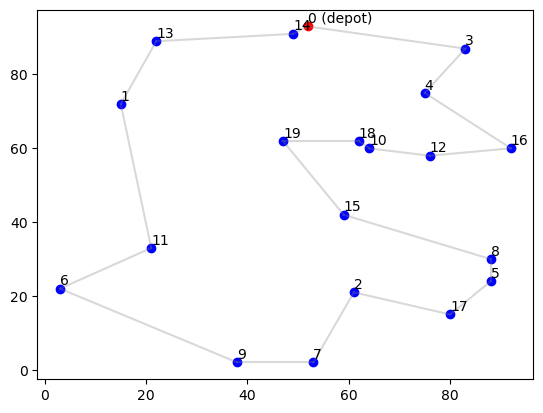

In [8]:
results_visualization(X,locations,num_locations)

In [13]:
def data_size(start,end):
    data_num = [i for i in range(start,end+1,10)]
    time_list = []
    objectval = []
    gap = []
    for i in range(start,end+1,10):
        m,locations,X=gurobi_solve(i)
        time_list.append(m.Runtime)
        if m.status != gp.GRB.OPTIMAL:
            gap.append(-1)
            objectval.append(-1)
        else:
            gap.append(m.MIPGap)
            objectval.append(m.objVal)

    plt.plot(data_num,time_list)
    plt.xlabel('Data Size')
    plt.ylabel('Time (s)')
    plt.title('')
    plt.show()
    
    plt.plot(data_num,objectval)
    plt.xlabel('Data Size')
    plt.ylabel('Objective')
    plt.show()

In [14]:
data_size(10,100)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110 rows, 110 columns and 585 nonzeros
Model fingerprint: 0x0737f54a
Variable types: 0 continuous, 110 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [6e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 18 rows and 11 columns
Presolve time: 0.00s
Presolved: 92 rows, 99 columns, 396 nonzeros
Variable types: 0 continuous, 99 integer (90 binary)
Found heuristic solution: objective 295.8945732

Root relaxation: objective 2.521630e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\gurobi\lib\site-packages\ipykernel\iostream.py", line 624, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


 1972546 563312     cutoff  109       632.17749  628.68580  0.55%  12.3 2657s
